In [52]:
%load_ext autoreload
%autoreload 2
import lensing
from astropy.io import fits as fits
import numpy as np
from astropy.table import Table
import clmm, sys
import matplotlib.pyplot as plt
from clmm import Cosmology
import clmm.dataops as da
from clmm.support import mock_data as mock
import clmm.galaxycluster as gc
from clmm.gcdata import GCData
from clmm.dataops import _compute_lensing_angles_flatsky
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 300 data

In [53]:
ff_0 = '/sps/lsst/users/ccombet/TheThreeHundred/maps/lensing/Max/snap_115/maps_0019_115_0.fits'
dat = fits.open(ff_0)
kappa = dat[0].data
shear1 = dat[1].data
shear2 = dat[2].data
z_cl = dat[0].header['ZL']
z_gal_0 = dat[0].header['ZS']
ra = np.arange(-1024,1024)*dat[0].header['CD1_1']
dec = np.arange(-1024,1024)*dat[0].header['CD2_2']
l_ra_deg = max(ra)-min(ra)
l_ra_rad = l_ra_deg * np.pi/180
field_size = l_ra_rad * cosmo.eval_da_z1z2(0, z_cl)

## Interpolation of shear1, shear2, kappa maps

In [54]:
shear1_map, shear2_map, kappa_map  = lensing.interp_shear_kappa_map(shear1, shear2, kappa, ra, dec)

# Catalog of background galaxies
## ra, dec, z from mock_CLMM

In [55]:
n_gal = 5000
cluster_m = 1e14
concentration = 4
mocks = mock.generate_galaxy_catalog(cluster_m, z_cl, concentration, cosmo,'chang13',cluster_ra=0., cluster_dec=0, 
                                             zsrc_max=2.5,field_size=field_size,
                                            ngals=n_gal)
zs = mocks['ztrue']
ras = np.random.random(n_gal)*(max(ra)-min(ra)) + min(ra)
decs = np.random.random(n_gal)*(max(dec)-min(dec)) + min(dec)

## shapes from 300 maps

In [70]:
e1, e2 = lensing.compute_ellipticity_from_lensing_map(z_cl, z_gal_0, ras, decs, zs, 
                                                      shear1_map, shear2_map, kappa_map, 
                                                      shapenoise = .2, cosmo = cosmo)

In [71]:
data_wl = Table()
data_wl['ra'], data_wl['dec'], data_wl['e1'], data_wl['e2'], data_wl['z'] = ras, decs, -e1, -e2, zs
data_wl = GCData(data_wl)
angsep, phi = _compute_lensing_angles_flatsky(0, 0, ras, decs)
data_wl['phi'] = phi
cluster_id = "CL_noisy_z"
cl = gc.GalaxyCluster(cluster_id, 0, 0,
                               z_cl, data_wl)

# Fit cluster mass from shear profile
## Estimation of excess surface density

In [72]:
cl.compute_tangential_and_cross_components(geometry="flat", is_deltasigma = True, cosmo = cosmo)
bin_edges = da.make_bins(0.1, field_size, 10, method='evenlog10width')
profile = cl.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)

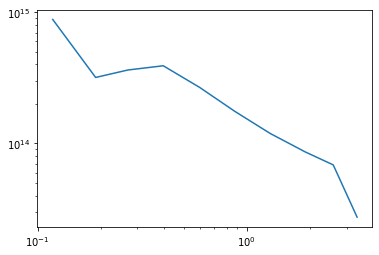

In [73]:
plt.loglog(profile['radius'], profile['gt'])

## Covariance matrix

In [74]:
def jackknife(catalog = 1, n_jk = 1):
    phi = np.linspace(-np.pi, np.pi, n_jk + 1)
    phi_bin = binning(phi)
    gt = []
    for phi_ in phi_bin:
        mask = (phi_[0]<cl.galcat['phi'])*(phi_[1]>cl.galcat['phi'])
        data_cut = clmm.GCData(cl.galcat[np.invert(mask)])
        cl_cut = clmm.GalaxyCluster('Stack', cl.ra, cl.dec, cl.z, data_cut)
        profile = cl_cut.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo)
        gt.append(profile['gt'])
    gt = np.array(gt)
    Xt = np.stack((gt.astype(float)), axis = 1)
    cov_t = ((n_jk-1)**2/n_jk)*np.cov(Xt, bias = False)
    return Xt, cov_t

In [75]:
X, cov = jackknife(catalog = cl, n_jk = 1000)

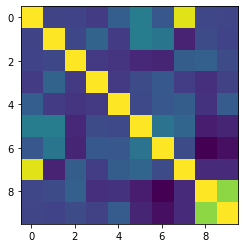

In [76]:
plt.imshow(np.corrcoef(cov))

## Modelling

In [77]:
moo = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo)
moo.set_concentration (4)

In [78]:
def ds_profile_model(r, logm, c):
    moo.set_mass (10.**logm)
    moo.set_concentration(c)
    gt_model = moo.eval_excess_surface_density (r, z_cl)
    return gt_model

## MCMC: fit of mass and concentration

In [79]:
def log_probability(theta, r, y, cov):
    logm, c = theta
    if c < 0.: return np.inf
    if 10**logm < 11: return np.inf
    model = ds_profile_model(r, logm, c)
    return -.5*np.sum((model-y)*np.linalg.inv(cov).dot(model-y))

In [80]:
import emcee
import corner
pos = [15, 4] + 1e-1 * np.random.randn(100, 2)
nwalkers, ndim = pos.shape

In [81]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args = (profile['radius'], profile['gt'], cov))
sampler.run_mcmc(pos, 200, progress=True);
flat_samples1 = sampler.get_chain(discard=100, thin=1, flat=True)

 12%|█▏        | 23/200 [00:05<00:39,  4.48it/s]/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:43<00:00,  4.58it/s]


Text(0, 0.5, '$c_{\\rm 200c}$')

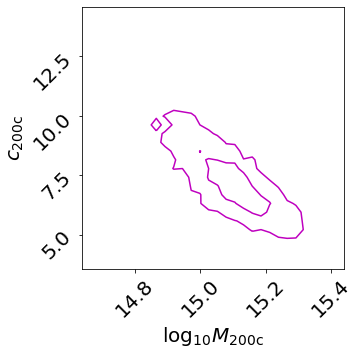

In [84]:
import corner
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
fig, ax = plt.subplots(2,2, figsize = (10,10))
mask = flat_samples1[:,1] > 0
fig = corner.corner(
    flat_samples1[flat_samples1[:,1] > 0], fig = fig, bins = 30, 
    plot_density = False, plot_datapoints = False,
    levels = [sigma1, sigma2], color = 'm');
fig.delaxes(ax[0,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[1,1])
ax[1,0].tick_params(axis='both', which = 'major', labelsize= 20)
ax[1,0].set_xlabel(r'$\log_{10}M_{\rm 200c}$', fontsize = 20)
ax[1,0].set_ylabel(r'$c_{\rm 200c}$', fontsize = 20)

[]

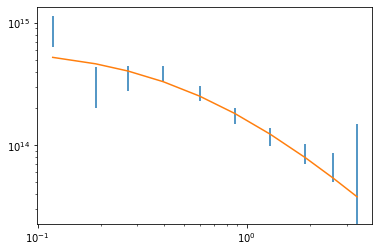

In [85]:
plt.errorbar(profile['radius'], profile['gt'], cov.diagonal()**.5, fmt = ' ')
plt.plot(profile['radius'], ds_profile_model(profile['radius'], *np.mean(flat_samples1, axis = 0)))
plt.loglog()